In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the raw emissions data
emissions = pd.read_csv("Datasets/historical_emissions.csv")

In [4]:
# Load total emissions predictions
predictions = pd.read_csv('emissions_predictions_2021_2030.csv')

In [5]:
# Filter for 2030 and get top 10
top10_2030 = predictions[predictions['Year'] == 2030].nlargest(10, 'Predicted_Emissions')

In [6]:
print("TOP 10 EMITTING COUNTRIES BY 2030 (Predicted):")
print(top10_2030[['Country', 'ISO', 'Predicted_Emissions']].to_string(index=False))

TOP 10 EMITTING COUNTRIES BY 2030 (Predicted):
                         Country ISO  Predicted_Emissions
                           China CHN         14910.261724
                           India IND          5264.269572
                   United States USA          4227.593121
                          Russia RUS          2108.453423
                       Indonesia IDN          1972.368816
                          Brazil BRA          1738.572568
                            Iran IRN          1046.531781
Democratic Republic of the Congo COD           929.471739
                           Japan JPN           803.712101
                        Pakistan PAK           784.976953


In [7]:
# Store the country codes for sector-wise analysis
TOP_COUNTRIES = top10_2030['ISO'].tolist()
print(f"\nCountry codes: {TOP_COUNTRIES}")


Country codes: ['CHN', 'IND', 'USA', 'RUS', 'IDN', 'BRA', 'IRN', 'COD', 'JPN', 'PAK']


 ALL SECTORS IN DATASET
 1. Total excluding LUCF
 2. Total including LUCF
 3. Energy
 4. Industrial Processes
 5. Agriculture
 6. Waste
 7. Land-Use Change and Forestry
 8. Bunker Fuels
 9. Electricity/Heat
10. Building
11. Manufacturing/Construction
12. Transportation
13. Other Fuel Combustion
14. Fugitive Emissions

 After removing 'Total' rows: 2328 rows

 ALL SECTORS RANKED BY EMISSIONS (2020)

Rank  Sector                                    Emissions        %
-----------------------------------------------------------------
1     Energy                                    69,645.64    42.2%
2     Electricity/Heat                          30,148.38    18.3%
3     Transportation                            13,587.64     8.2%
4     Manufacturing/Construction                12,410.38     7.5%
5     Agriculture                               11,723.97     7.1%
6     Fugitive Emissions                         6,407.69     3.9%
7     Industrial Processes                       6,247.24     3

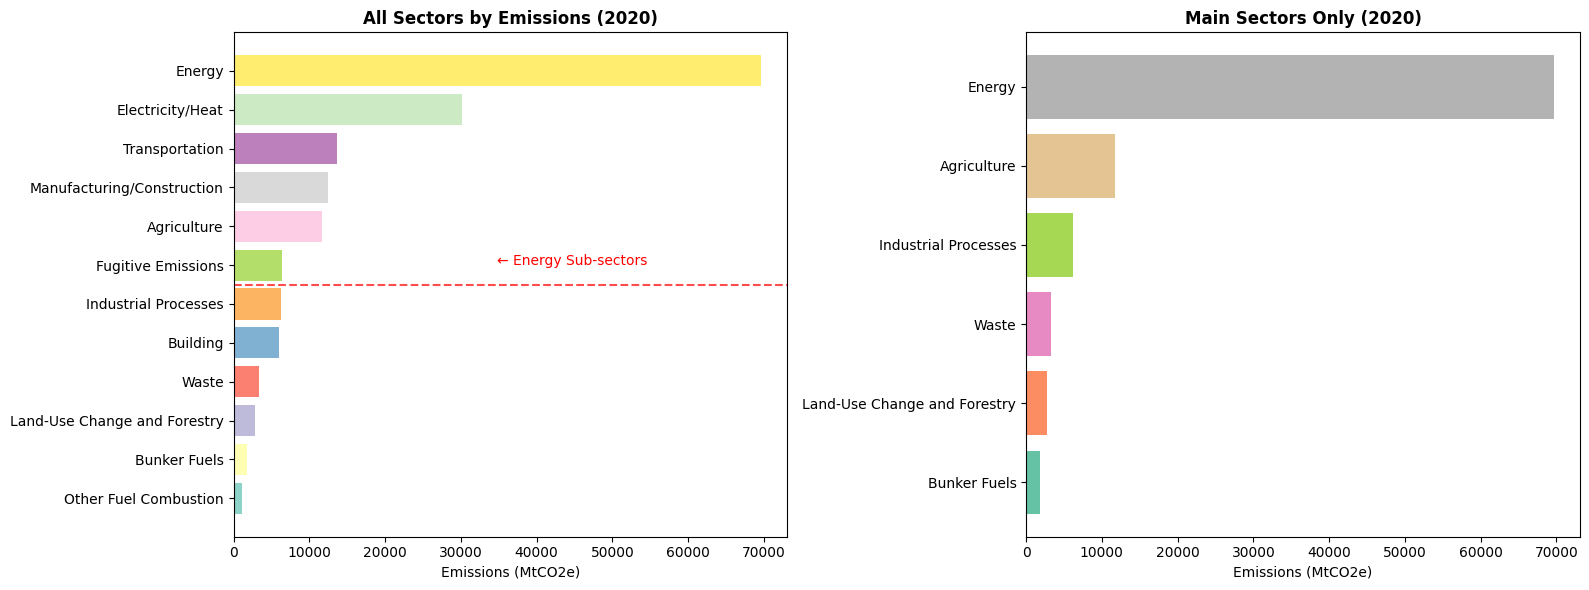


 BONUS: DETECTING SECTOR HIERARCHY

Energy (main sector):     69,645.64
Sum of Energy sub-sectors: 69,645.06
Difference:                0.58
 Confirmed: Sub-sectors sum up to Energy (avoid double-counting!)


In [8]:
# ============================================================================
# AUTOMATICALLY DISCOVER TOP CONTRIBUTING SECTORS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Year columns
year_cols = [col for col in emissions.columns if col.isdigit()]
latest_year = max(year_cols)

# ============================================================================
# STEP 1: SEE ALL UNIQUE SECTORS
# ============================================================================

print("="*70)
print(" ALL SECTORS IN DATASET")
print("="*70)

all_sectors = emissions['Sector'].unique()
for i, sector in enumerate(all_sectors, 1):
    print(f"{i:2}. {sector}")

# ============================================================================
# STEP 2: FILTER OUT "TOTAL" ROWS AND GAS TYPES
# ============================================================================

# Filter for All GHG only
emissions_ghg = emissions[emissions['Gas'] == 'All GHG'].copy()

# Remove rows that are TOTALS (they sum up other sectors)
total_keywords = ['Total']
emissions_filtered = emissions_ghg[
    ~emissions_ghg['Sector'].str.contains('|'.join(total_keywords), case=False)
]

print(f"\n After removing 'Total' rows: {len(emissions_filtered)} rows")

# ============================================================================
# STEP 3: CALCULATE GLOBAL EMISSIONS BY SECTOR
# ============================================================================

sector_emissions = emissions_filtered.groupby('Sector')[latest_year].sum().sort_values(ascending=False)

print("\n" + "="*70)
print(f" ALL SECTORS RANKED BY EMISSIONS ({latest_year})")
print("="*70)

total = sector_emissions.sum()
print(f"\n{'Rank':<5} {'Sector':<35} {'Emissions':>15} {'%':>8}")
print("-"*65)
for rank, (sector, value) in enumerate(sector_emissions.items(), 1):
    pct = (value / total) * 100
    print(f"{rank:<5} {sector:<35} {value:>15,.2f} {pct:>7.1f}%")

# ============================================================================
# STEP 4: IDENTIFY MAIN SECTORS (EXCLUDE SUB-SECTORS)
# ============================================================================

# Sub-sectors are typically part of "Energy" - we can identify them:
energy_subsectors = [
    'Electricity/Heat', 'Transportation', 'Manufacturing/Construction',
    'Building', 'Fugitive Emissions', 'Other Fuel Combustion'
]

# Main sectors = All sectors MINUS energy sub-sectors
main_sectors_emissions = sector_emissions[~sector_emissions.index.isin(energy_subsectors)]

print("\n" + "="*70)
print(f" MAIN SECTORS (Excluding Energy Sub-sectors)")
print("="*70)

main_total = main_sectors_emissions.sum()
print(f"\n{'Rank':<5} {'Sector':<35} {'Emissions':>15} {'%':>8}")
print("-"*65)
for rank, (sector, value) in enumerate(main_sectors_emissions.items(), 1):
    pct = (value / main_total) * 100
    print(f"{rank:<5} {sector:<35} {value:>15,.2f} {pct:>7.1f}%")

# ============================================================================
# STEP 5: AUTOMATICALLY SELECT TOP N SECTORS
# ============================================================================

# Select top 5 main sectors automatically
TOP_N = 5
TOP_SECTORS = main_sectors_emissions.head(TOP_N).index.tolist()

print("\n" + "="*70)
print(f" AUTOMATICALLY SELECTED TOP {TOP_N} SECTORS:")
print("="*70)
for i, sector in enumerate(TOP_SECTORS, 1):
    pct = (main_sectors_emissions[sector] / main_total) * 100
    print(f"{i}. {sector} ({pct:.1f}%)")

# ============================================================================
# STEP 6: VISUALIZE
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All sectors (including sub-sectors)
colors1 = plt.cm.Set3(np.linspace(0, 1, len(sector_emissions)))
axes[0].barh(sector_emissions.index[::-1], sector_emissions.values[::-1], color=colors1)
axes[0].set_xlabel('Emissions (MtCO2e)')
axes[0].set_title(f'All Sectors by Emissions ({latest_year})', fontweight='bold')
axes[0].axhline(y=len(sector_emissions) - len(main_sectors_emissions) - 0.5, 
                color='red', linestyle='--', alpha=0.7)
axes[0].text(sector_emissions.max() * 0.5, len(sector_emissions) - len(main_sectors_emissions),
             '← Energy Sub-sectors', color='red', fontsize=10)

# Main sectors only
colors2 = plt.cm.Set2(np.linspace(0, 1, len(main_sectors_emissions)))
axes[1].barh(main_sectors_emissions.index[::-1], main_sectors_emissions.values[::-1], color=colors2)
axes[1].set_xlabel('Emissions (MtCO2e)')
axes[1].set_title(f'Main Sectors Only ({latest_year})', fontweight='bold')

plt.tight_layout()
plt.savefig('sector_discovery.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# STEP 7: ALTERNATIVE - FULLY AUTOMATIC WITH HIERARCHY DETECTION
# ============================================================================

print("\n" + "="*70)
print(" BONUS: DETECTING SECTOR HIERARCHY")
print("="*70)

# Check if Energy ≈ sum of its sub-sectors
energy_main = emissions_filtered[emissions_filtered['Sector'] == 'Energy'][latest_year].sum()
energy_subs_total = emissions_filtered[
    emissions_filtered['Sector'].isin(energy_subsectors)
][latest_year].sum()

print(f"\nEnergy (main sector):     {energy_main:,.2f}")
print(f"Sum of Energy sub-sectors: {energy_subs_total:,.2f}")
print(f"Difference:                {abs(energy_main - energy_subs_total):,.2f}")

if abs(energy_main - energy_subs_total) / energy_main < 0.1:  # Within 10%
    print(" Confirmed: Sub-sectors sum up to Energy (avoid double-counting!)")
else:
    print(" Note: Values don't match exactly - check data")

In [9]:
# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# ============================================================================
# STEP 1: LOAD AND EXPLORE DATA
# ============================================================================

print("="*70)
print(" DATASET OVERVIEW")
print("="*70)
print(f"Shape: {emissions.shape}")
print(f"\nColumns: {emissions.columns.tolist()}")
print(f"\nUnique Countries: {emissions['Country'].nunique()}")
print(f"Unique Sectors: {emissions['Sector'].nunique()}")
print(f"Unique Gases: {emissions['Gas'].nunique()}")

# Year columns
year_cols = [col for col in emissions.columns if col.isdigit()]
print(f"Years covered: {min(year_cols)} - {max(year_cols)}")

 DATASET OVERVIEW
Shape: (11058, 37)

Columns: ['ISO', 'Country', 'Data source', 'Sector', 'Gas', 'Unit', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007', '2006', '2005', '2004', '2003', '2002', '2001', '2000', '1999', '1998', '1997', '1996', '1995', '1994', '1993', '1992', '1991', '1990']

Unique Countries: 194
Unique Sectors: 14
Unique Gases: 5
Years covered: 1990 - 2020


In [10]:
# ============================================================================
# STEP 2: EXPLORE SECTORS
# ============================================================================

print("\n" + "="*70)
print(" ALL SECTORS IN DATASET")
print("="*70)
sectors = emissions['Sector'].unique()
for i, sector in enumerate(sectors, 1):
    print(f"{i:2}. {sector}")


 ALL SECTORS IN DATASET
 1. Total excluding LUCF
 2. Total including LUCF
 3. Energy
 4. Industrial Processes
 5. Agriculture
 6. Waste
 7. Land-Use Change and Forestry
 8. Bunker Fuels
 9. Electricity/Heat
10. Building
11. Manufacturing/Construction
12. Transportation
13. Other Fuel Combustion
14. Fugitive Emissions


In [11]:
# ============================================================================
# STEP 3: FILTER FOR ALL GHG AND MAIN SECTORS
# ============================================================================

# Main sectors (excluding totals and sub-sectors)
MAIN_SECTORS = [
    'Energy',
    'Industrial Processes',
    'Agriculture',
    'Waste',
    'Land-Use Change and Forestry'
]

# Filter for All GHG and main sectors
sector_data = emissions[
    (emissions['Gas'] == 'All GHG') &
    (emissions['Sector'].isin(MAIN_SECTORS))
].copy()

print(f"\n Filtered data shape: {sector_data.shape}")


 Filtered data shape: (970, 37)


In [12]:
# ============================================================================
# STEP 4: GLOBAL SECTOR CONTRIBUTION ANALYSIS
# ============================================================================

print("\n" + "="*70)
print(" GLOBAL SECTOR CONTRIBUTIONS")
print("="*70)

# Calculate total emissions by sector for latest year
latest_year = max(year_cols)
sector_totals = sector_data.groupby('Sector')[latest_year].sum().sort_values(ascending=False)

print(f"\n Sector Emissions in {latest_year} (MtCO2e):")
print("-"*50)
total_emissions = sector_totals.sum()
for sector, value in sector_totals.items():
    pct = (value / total_emissions) * 100
    print(f"{sector:35} {value:>12,.2f}  ({pct:5.1f}%)")
print("-"*50)
print(f"{'TOTAL':35} {total_emissions:>12,.2f}  (100.0%)")


 GLOBAL SECTOR CONTRIBUTIONS

 Sector Emissions in 2020 (MtCO2e):
--------------------------------------------------
Energy                                 69,645.64  ( 74.3%)
Agriculture                            11,723.97  ( 12.5%)
Industrial Processes                    6,247.24  (  6.7%)
Waste                                   3,305.08  (  3.5%)
Land-Use Change and Forestry            2,778.32  (  3.0%)
--------------------------------------------------
TOTAL                                  93,700.25  (100.0%)


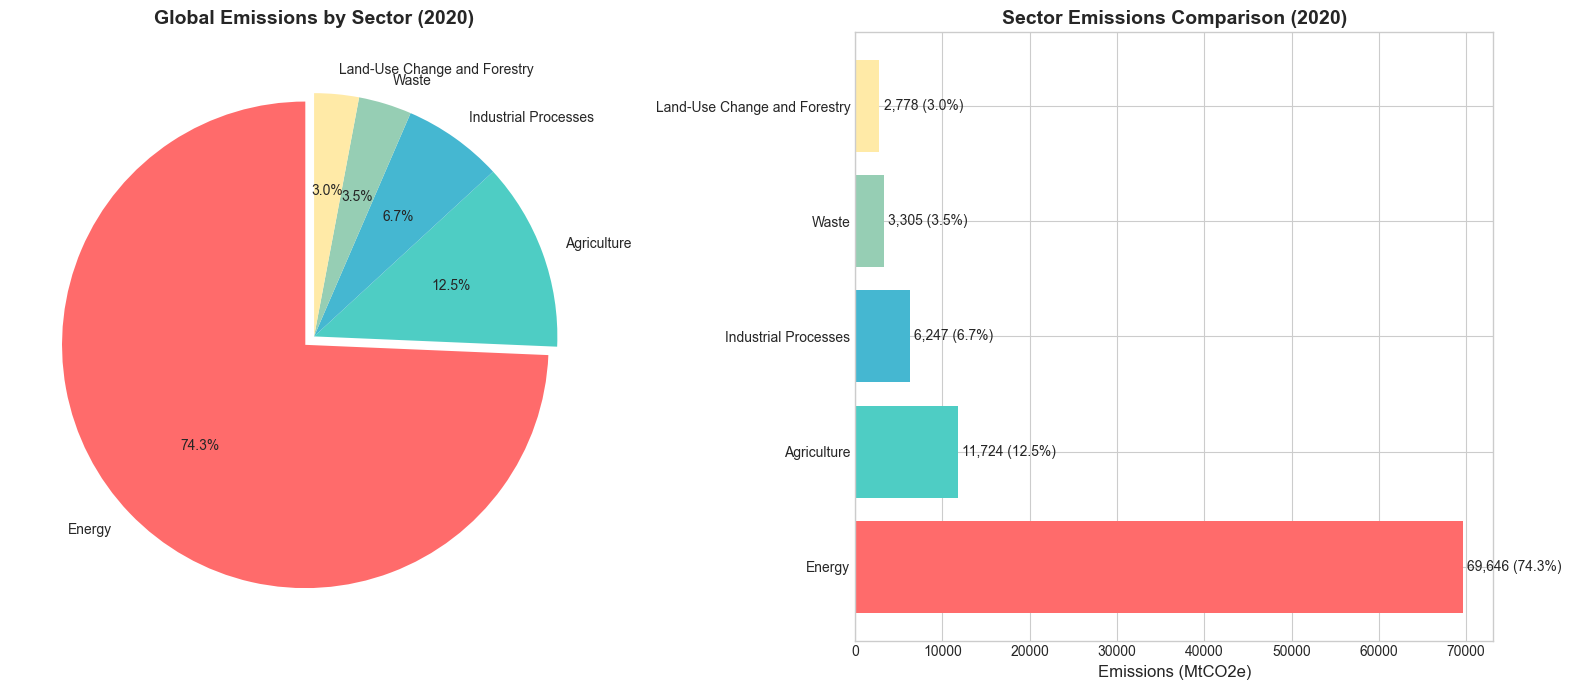

In [13]:
# ============================================================================
# STEP 5: VISUALIZATION - SECTOR PIE CHART
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Pie chart
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4', '#ffeaa7']
explode = [0.05 if i == 0 else 0 for i in range(len(sector_totals))]

axes[0].pie(sector_totals, labels=sector_totals.index, autopct='%1.1f%%', 
            colors=colors, explode=explode, startangle=90, 
            textprops={'fontsize': 10})
axes[0].set_title(f'Global Emissions by Sector ({latest_year})', fontsize=14, fontweight='bold')

# Bar chart
bars = axes[1].barh(sector_totals.index, sector_totals.values, color=colors)
axes[1].set_xlabel('Emissions (MtCO2e)', fontsize=12)
axes[1].set_title(f'Sector Emissions Comparison ({latest_year})', fontsize=14, fontweight='bold')
for i, bar in enumerate(bars):
    width = bar.get_width()
    pct = (width / total_emissions) * 100
    axes[1].text(width + 500, bar.get_y() + bar.get_height()/2, 
                 f'{width:,.0f} ({pct:.1f}%)', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('sector_contribution_overview.png', dpi=300, bbox_inches='tight')
plt.show()


 SECTOR TRENDS OVER TIME


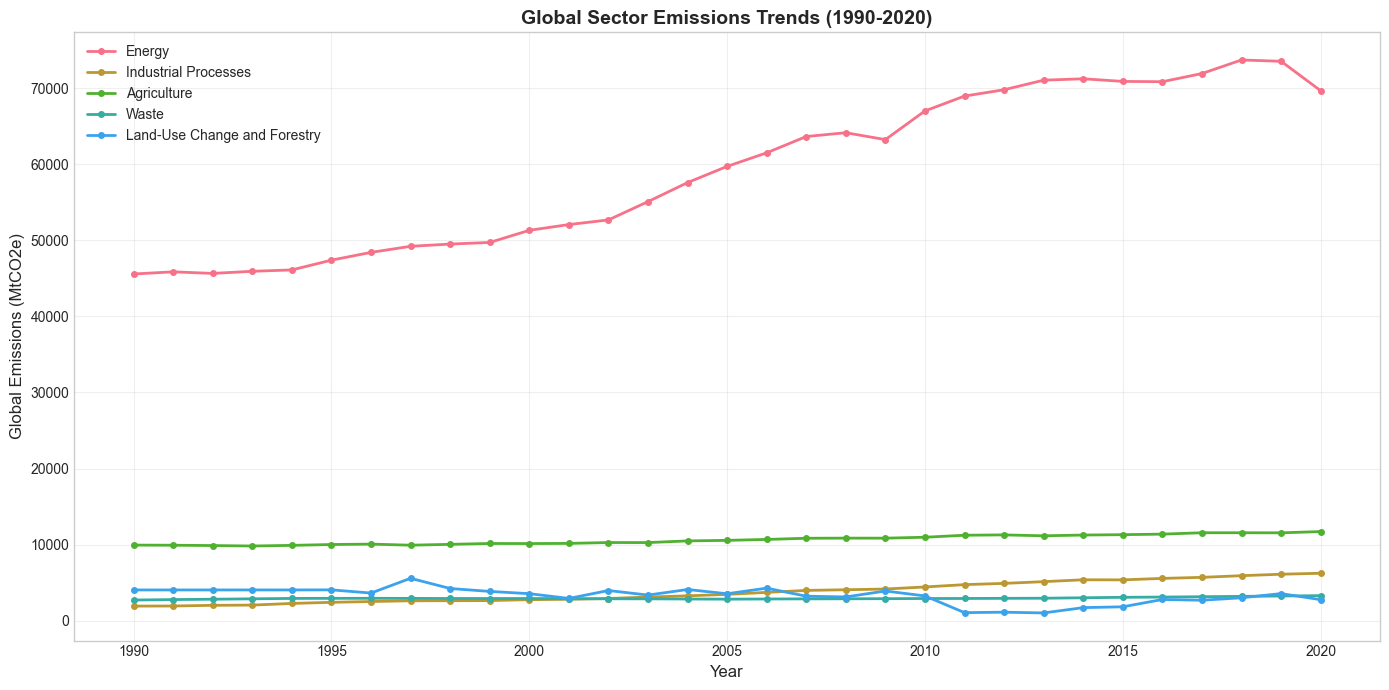

In [14]:
# ============================================================================
# STEP 6: SECTOR TRENDS OVER TIME
# ============================================================================

print("\n" + "="*70)
print(" SECTOR TRENDS OVER TIME")
print("="*70)

# Reshape to long format for time series
sector_long = sector_data.melt(
    id_vars=['ISO', 'Country', 'Sector'],
    value_vars=year_cols,
    var_name='Year',
    value_name='Emissions'
)
sector_long['Year'] = sector_long['Year'].astype(int)

# Global sector trends
global_trends = sector_long.groupby(['Year', 'Sector'])['Emissions'].sum().reset_index()

# Plot trends
fig, ax = plt.subplots(figsize=(14, 7))

for sector in MAIN_SECTORS:
    data = global_trends[global_trends['Sector'] == sector]
    ax.plot(data['Year'], data['Emissions'], marker='o', linewidth=2, 
            markersize=4, label=sector)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Global Emissions (MtCO2e)', fontsize=12)
ax.set_title('Global Sector Emissions Trends (1990-2020)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sector_trends_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Calculate growth rates
first_year = min(year_cols)
print(f"\n Sector Growth from {first_year} to {latest_year}:")
print("-"*60)
for sector in MAIN_SECTORS:
    start_val = sector_data[sector_data['Sector'] == sector][first_year].sum()
    end_val = sector_data[sector_data['Sector'] == sector][latest_year].sum()
    growth = ((end_val - start_val) / start_val) * 100 if start_val != 0 else 0
    print(f"{sector:35} {growth:>8.1f}% growth")

# ============================================================================
# STEP 7: TOP 10 COUNTRIES BY TOTAL EMISSIONS
# ============================================================================

print("\n" + "="*70)
print(" TOP 10 COUNTRIES BY TOTAL EMISSIONS (2020)")
print("="*70)

# Get total emissions (sum of all sectors) per country
country_totals = sector_data.groupby(['ISO', 'Country'])[latest_year].sum().sort_values(ascending=False)
top10_countries = country_totals.head(10)

print(f"\n{'Rank':<5} {'Country':<25} {'Emissions (MtCO2e)':<20} {'% of Global':<10}")
print("-"*60)
global_total = country_totals.sum()
for rank, ((iso, country), value) in enumerate(top10_countries.items(), 1):
    pct = (value / global_total) * 100
    print(f"{rank:<5} {country:<25} {value:>15,.2f}     {pct:>6.1f}%")

TOP10_ISOS = top10_countries.index.get_level_values('ISO').tolist()


 Sector Growth from 1990 to 2020:
------------------------------------------------------------
Energy                                  52.8% growth
Industrial Processes                   223.0% growth
Agriculture                             17.8% growth
Waste                                   21.1% growth
Land-Use Change and Forestry           -31.5% growth

 TOP 10 COUNTRIES BY TOTAL EMISSIONS (2020)

Rank  Country                   Emissions (MtCO2e)   % of Global
------------------------------------------------------------
1     World                           47,513.15       50.7%
2     China                           12,295.63       13.1%
3     United States                    5,289.13        5.6%
4     India                            3,166.95        3.4%
5     Russia                           1,799.97        1.9%
6     Indonesia                        1,475.82        1.6%
7     Brazil                           1,469.66        1.6%
8     Japan                            1,062.77